# Study the MSE

So the MSE that Majid is refering to is the MSE obtained by regressing the absorbances against the concentrations at the wavelength of greatest variance in absorbances.

Majid's hypothesis is that: "by incorporating more data than just the absorbances at the single wavelength of greatest variance, we can significantly reduce the MSE.

To test this I will:
1. calculate what the MSE is at the wavelength of highest variance
2. Remove wavelengths of high correlation between each other
   1. 
3. Fit a lasso model using the data from all wavelengths of the data
   1. vary the lasso selection threshold ($\alpha$) to identify how the number of data points affects the MSE


# load imports and data

In [2]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
# use lasso from sklearn
from sklearn.linear_model import Lasso
from tqdm import tqdm
import seaborn as sns
from itertools import combinations
import math
import matplotlib.pyplot as plt

In [3]:
# load the data from the previous part
data = pd.read_csv('../p01_extract_data_from_fig/colorimetry_data_PS_extracted.csv')
data.rename(columns={'Wavelength (nm)':"wavelength",'Smoothed Absorbance':"sm_absorbance"}, inplace=True)

# Determine Wavelength of highest Variance and fit model

In [4]:
wv_highest_variance = None
for wv in np.unique(data['wavelength']):
    df = data[data['wavelength'] == wv]
    if wv_highest_variance is None or df['sm_absorbance'].var() > wv_highest_variance['sm_absorbance'].var():
        wv_highest_variance = df
print(wv_highest_variance['wavelength'].values[0],wv_highest_variance['sm_absorbance'].var())

652.1784232365146 0.003993509394281987


In [5]:
wv_highest_variance

,wavelength,Absorbance,Color,Concentration,sm_absorbance,webcolor
195,652.178423,0.284016,black,0,0.282795,#000000
578,652.178423,0.275820,red,5,0.275289,#FF0001
961,652.178423,0.240574,blue,10,0.239817,#0D0CF9
1344,652.178423,0.224180,green,20,0.224142,#017F03
1727,652.178423,0.191393,pink,30,0.190823,#FF02FF
2110,652.178423,0.159426,magenta,40,0.159388,#8604B4
2493,652.178423,0.144672,navy,50,0.144475,#0203A6
2876,652.178423,0.128279,orange,60,0.128354,#FF870C
3259,652.178423,0.123361,purple,80,0.122924,#9011EE
3642,652.178423,0.118443,salmon,100,0.118463,#FF0381


In [6]:
# fit an OLS model with absorbance as the dependent variable and the concentration as the independent variable
# use R model syntax
model = sm.OLS.from_formula('Concentration ~ sm_absorbance', data=wv_highest_variance)
results = model.fit()
# print the MSE of the model
print(results.mse_resid)
results.summary()

168.79064786196122


c:\Users\craut\.virtualenvs\colorimetry_ML-6CtRR2jE\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Concentration   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     50.79
Date:                Sat, 15 Feb 2025   Prob (F-statistic):           9.94e-05
Time:                        07:54:20   Log-Likelihood:                -38.717
No. Observations:                  10   AIC:                             81.43
Df Residuals:                       8   BIC:                             82.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       131.6291     13.565      9.704      0.000     100.348     162.910
sm_absorbance  -488.3677     68.529     -7.126      0.000    -646.396    -330.339
==============================================================================
Omnibus:                        3.152   Durbin-Watson:                   0.635
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                1.323
Skew:                           0.891   Prob(JB):                        0.516
Kurtosis:                       2.997   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Remove wavelengths of high correlation

In [7]:
# first transform the data to wide format
wide_data = data.pivot(index='Concentration', columns='wavelength', values='sm_absorbance')
rename_dict = {c:f"abs_wv_{round(c,3)}" for c in wide_data.columns}
wide_data = wide_data.rename(columns=rename_dict).reset_index()
X = wide_data.drop(columns='Concentration')
y = wide_data['Concentration']

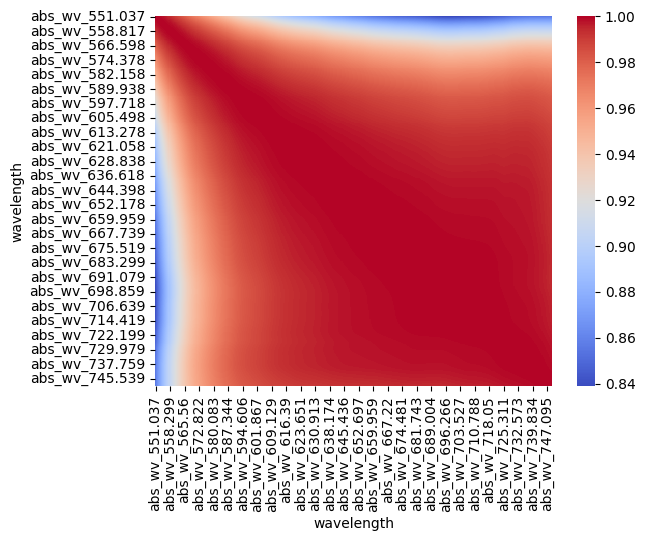

In [8]:
# first study the correlation between the variables by using a correlation heatmap
ax = sns.heatmap(X.corr(), cmap='coolwarm')

So the protocol to remove the correlated features is a typical protocol:
1. rank the features by order of increasing MSE in a sv model against concentration
   1. we want to process the most informative wavelengths 1st
   2. An alternative would be to sort the wavelengths by variance (prefer to keep the wavelength with highest variance 1st)
   3. Average absorbtions every 10 nms
2. iterate through the features keeping each feature if its correlation threshold between all the previously kept features is less than a threshold
   1. use 0.95 as the threshold (taken from "mid" of heatmap)

## attempt 1: Sort Wavelengths by importance to concentration

In [9]:
# first build a correlation matrix for lookup
corr_matrix = X.corr().abs()

# now fit the sv linear regression models for all the features and map each feature to the MSE
mse_map = {}
for col in tqdm(X.columns):
    df = pd.DataFrame(wide_data[[col, 'Concentration']])
    df.rename(columns={col:"wv"}, inplace=True)
    model = sm.OLS.from_formula(f'Concentration ~ wv', data=df)
    results = model.fit()
    mse_map[col] = results.mse_resid
# sort the features by the MSE
sorted_features = sorted(mse_map, key=mse_map.get)
thresh = 0.999 # 1 - 1e-4
kept_features = []
for test_feat in sorted_features:
    for feat in kept_features:
        if corr_matrix.loc[test_feat, feat] > thresh:
            break
    else:
        kept_features.append(test_feat)
print(kept_features)

100%|██████████| 383/383 [00:01<00:00, 230.05it/s]


['abs_wv_594.087', 'abs_wv_606.535', 'abs_wv_585.788', 'abs_wv_621.577', 'abs_wv_578.527', 'abs_wv_571.784', 'abs_wv_645.436', 'abs_wv_738.797', 'abs_wv_566.598', 'abs_wv_679.668', 'abs_wv_562.448', 'abs_wv_558.299', 'abs_wv_554.668', 'abs_wv_551.556']


In [10]:
# # this is the wavelength of highest variance
# kept_features.append("abs_wv_652.178")

In [11]:
print(len(kept_features), "abs_wv_652.178" in kept_features)

14 False


In [12]:
X_filt = X[kept_features]
print(X_filt.shape)

(10, 14)


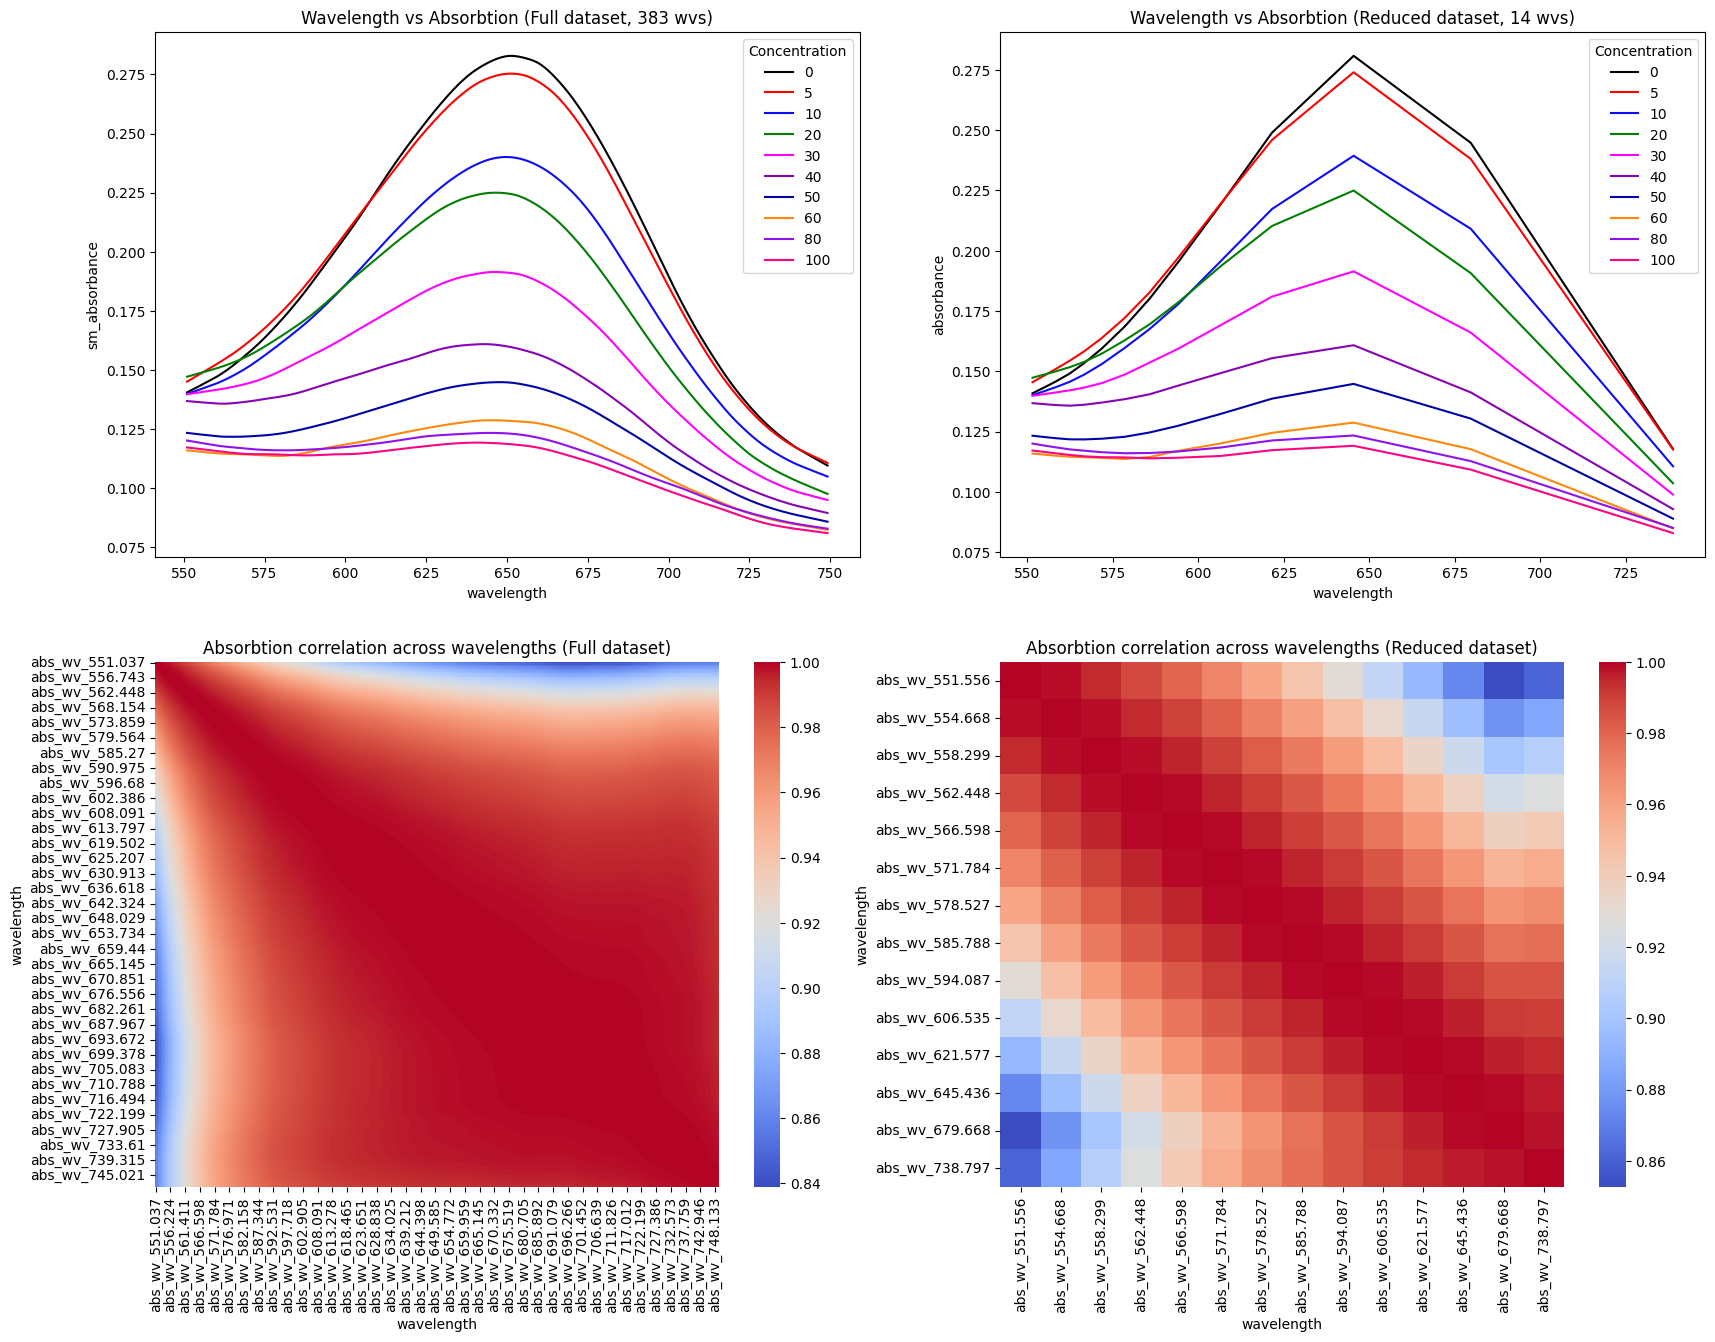

In [13]:
# compare the original plot and the "reduced" plot
# convert the data to long format
long_data = X_filt.copy(deep=True)
long_data['Concentration'] = y
long_data = long_data.melt(id_vars='Concentration', var_name='wavelength', value_name='absorbance')
long_data['wavelength'] = long_data['wavelength'].str.replace('abs_wv_', '').astype(float)

# create 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()
webcolors = ["#000000","#FF0001","#0D0CF9","#017F03","#FF02FF","#8604B4","#0203A6","#FF870C","#9011EE","#FF0381"]
sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[0])
axs[0].set_title(f"Wavelength vs Absorbtion (Full dataset, {len(data)//len(y)} wvs)")
sns.lineplot(data=long_data, x="wavelength", y="absorbance", hue="Concentration", palette=webcolors, ax=axs[1])
axs[1].set_title(f"Wavelength vs Absorbtion (Reduced dataset, {len(long_data)//len(y)} wvs)")
# now compare the correlation heatmaps
sns.heatmap(X[sorted(X.columns)].corr(), cmap='coolwarm', ax=axs[2])
axs[2].set_title("Absorbtion correlation across wavelengths (Full dataset)")
sns.heatmap(X_filt[sorted(X_filt.columns)].corr(), cmap='coolwarm', ax=axs[3])
axs[3].set_title("Absorbtion correlation across wavelengths (Reduced dataset)")
plt.show()

### Iteratively add additional features and measure the drop in MSE

In [14]:
# first we have to fix the names of the columns
# we want to replace all '.' with '_' in the column names
X_filt.columns = X_filt.columns.str.replace('.', '_')

Xy_filt = X_filt.copy(deep=True)
Xy_filt['Concentration'] = y

def determine_best_feat_2_add(current_feats, Xy_filt):
    cur_formula = 'Concentration ~ ' + ' + '.join(current_feats)
    
    # first fit the model with the current features
    model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
    results = model.fit()
    cur_mse = results.mse_resid
    
    mse_map = {}
    for col in Xy_filt.columns:
        if col == 'Concentration' or col in current_feats:
            continue
        model = sm.OLS.from_formula(f'{cur_formula} + {col}', data=Xy_filt)
        results = model.fit()
        #print(f'{cur_formula} + {col}', results.mse_resid)
        mse_map[col] = results.mse_resid
    best_feat = min(mse_map, key=mse_map.get)
    if mse_map[best_feat] < cur_mse:
        return best_feat, mse_map[best_feat]
    else:
        return None, None

model = sm.OLS.from_formula(f'Concentration ~ {kept_features[0].replace(".","_")}', data=Xy_filt)
results = model.fit()

data_list = [{'n_feats':1, 'best_feat':kept_features[0].replace(".","_"), 'best_mse':results.mse_resid}]
cur_feats = [data_list[0]['best_feat']]
for n_feats in range(2, 10):
    best_feat, best_mse = determine_best_feat_2_add(cur_feats, Xy_filt)
    if best_feat is None:
        break
    cur_feats.append(best_feat)
    data_list.append({'n_feats':n_feats, 'best_feat':best_feat, 'best_mse':best_mse})
    print(n_feats, best_feat, best_mse)
pd.DataFrame(data_list)

,n_feats,best_feat,best_mse
0,1,abs_wv_594_087,144.886022


### Try all combinations of k = 1 ... 8 features and see which one has the lowest MSE 

In [15]:
def get_best_comb_feats(k,df):
    best_comb = []
    best_mse = np.inf
    feats = [c for c in df.columns if c != 'Concentration']
    all_data_list = []
    # iterate over all possible combinations of k features
    total_comb = math.comb(len(feats), k)
    for comb in tqdm(combinations(feats, k), total=total_comb):
        cur_formula = 'Concentration ~ ' + ' + '.join(comb)
        model = sm.OLS.from_formula(cur_formula, data=df)
        results = model.fit()
        cur_mse = results.mse_resid
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_comb = comb
        all_data_list.append({'n_feats':k, 'comb':comb, 'mse':cur_mse})
    df = pd.DataFrame(all_data_list)
    return best_comb, best_mse, df

data_list = []
all_dfs = []
for k in range(1, 9):
    best_comb, best_mse,df = get_best_comb_feats(k, Xy_filt)
    data_list.append({'n_feats':k, 'best_feats':best_comb, 'best_mse':best_mse})
    all_dfs.append(df)
    print(k, best_comb, best_mse)
att1_data = pd.DataFrame(data_list)

100%|██████████| 14/14 [00:00<00:00, 291.34it/s]


1 ('abs_wv_594_087',) 144.88602198849782


100%|██████████| 91/91 [00:00<00:00, 219.85it/s]


2 ('abs_wv_738_797', 'abs_wv_551_556') 153.3561767636922


100%|██████████| 364/364 [00:01<00:00, 187.02it/s]


3 ('abs_wv_621_577', 'abs_wv_578_527', 'abs_wv_554_668') 64.09019643415489


100%|██████████| 1001/1001 [00:06<00:00, 164.82it/s]


4 ('abs_wv_621_577', 'abs_wv_578_527', 'abs_wv_571_784', 'abs_wv_551_556') 67.5436287809288


100%|██████████| 2002/2002 [00:14<00:00, 134.99it/s]


5 ('abs_wv_566_598', 'abs_wv_679_668', 'abs_wv_562_448', 'abs_wv_558_299', 'abs_wv_554_668') 47.333864965316934


100%|██████████| 3003/3003 [00:22<00:00, 133.98it/s]


6 ('abs_wv_566_598', 'abs_wv_679_668', 'abs_wv_562_448', 'abs_wv_558_299', 'abs_wv_554_668', 'abs_wv_551_556') 11.532531026701443


100%|██████████| 3432/3432 [00:27<00:00, 123.43it/s]


7 ('abs_wv_594_087', 'abs_wv_738_797', 'abs_wv_566_598', 'abs_wv_562_448', 'abs_wv_558_299', 'abs_wv_554_668', 'abs_wv_551_556') 0.6227467838203804


100%|██████████| 3003/3003 [00:27<00:00, 111.00it/s]


8 ('abs_wv_594_087', 'abs_wv_606_535', 'abs_wv_621_577', 'abs_wv_645_436', 'abs_wv_738_797', 'abs_wv_679_668', 'abs_wv_554_668', 'abs_wv_551_556') 0.00030548851445682406
 ('abs_wv_594_087', 'abs_wv_606_535', 'abs_wv_621_577', 'abs_wv_645_436', 'abs_wv_738_797', 'abs_wv_679_668', 'abs_wv_554_668', 'abs_wv_551_556') 0.00030548851445682406


In [16]:
# sns.boxplot(data=pd.concat(all_dfs), x='n_feats', y='mse')

## attempt 2: sort wavelengths by variance

In [17]:
# now fit the sv linear regression models for all the features and map each feature to the MSE
var_map = {}
for col in tqdm([c for c in wide_data.columns if c != 'Concentration']):
    var_map[col] = wide_data[col].var()
# sort the features by the variance descending
sorted_features = sorted(mse_map, key=var_map.get, reverse=True)
thresh = 0.999 # 1 - 1e-4
kept_features = []
for test_feat in sorted_features:
    for feat in kept_features:
        if corr_matrix.loc[test_feat, feat] > thresh:
            break
    else:
        kept_features.append(test_feat)
print(kept_features)

100%|██████████| 383/383 [00:00<00:00, 15954.26it/s]


['abs_wv_652.178', 'abs_wv_627.801', 'abs_wv_687.967', 'abs_wv_609.129', 'abs_wv_596.162', 'abs_wv_587.344', 'abs_wv_580.083', 'abs_wv_573.34', 'abs_wv_567.635', 'abs_wv_727.386', 'abs_wv_562.967', 'abs_wv_558.817', 'abs_wv_555.187', 'abs_wv_552.075', 'abs_wv_744.502']


In [18]:
print(len(kept_features), "abs_wv_652.178" in kept_features)

15 True
 True


In [19]:
X_filt = X[kept_features]
print(X_filt.shape)

(10, 15)


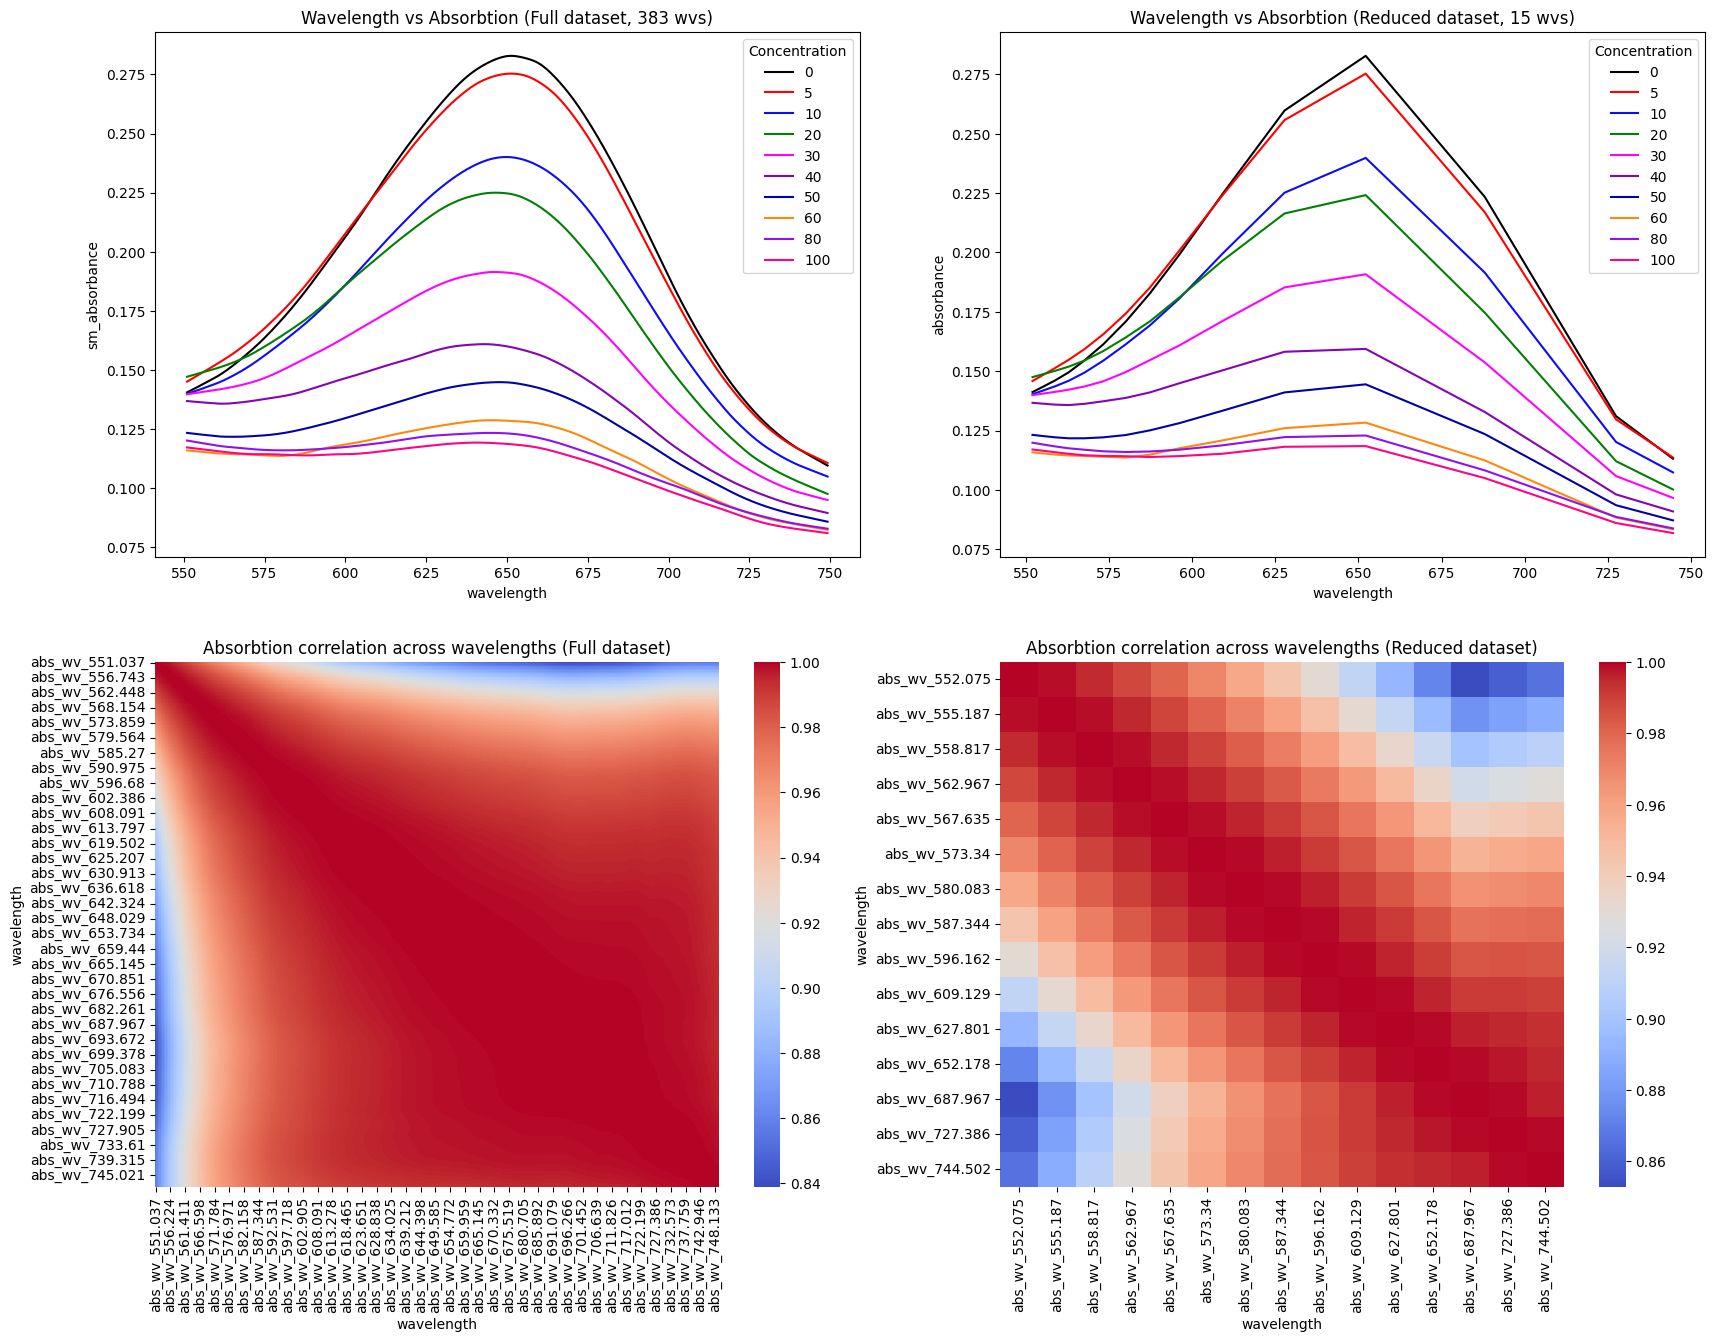

In [20]:
long_data = X_filt.copy(deep=True)
long_data['Concentration'] = y
long_data = long_data.melt(id_vars='Concentration', var_name='wavelength', value_name='absorbance')
long_data['wavelength'] = long_data['wavelength'].str.replace('abs_wv_', '').astype(float)

# create 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()
webcolors = ["#000000","#FF0001","#0D0CF9","#017F03","#FF02FF","#8604B4","#0203A6","#FF870C","#9011EE","#FF0381"]
sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[0])
axs[0].set_title(f"Wavelength vs Absorbtion (Full dataset, {len(data)//len(y)} wvs)")
sns.lineplot(data=long_data, x="wavelength", y="absorbance", hue="Concentration", palette=webcolors, ax=axs[1])
axs[1].set_title(f"Wavelength vs Absorbtion (Reduced dataset, {len(long_data)//len(y)} wvs)")
# now compare the correlation heatmaps
sns.heatmap(X[sorted(X.columns)].corr(), cmap='coolwarm', ax=axs[2])
axs[2].set_title("Absorbtion correlation across wavelengths (Full dataset)")
sns.heatmap(X_filt[sorted(X_filt.columns)].corr(), cmap='coolwarm', ax=axs[3])
axs[3].set_title("Absorbtion correlation across wavelengths (Reduced dataset)")
plt.show()

### Iteratively add additional features and measure the drop in MSE

In [21]:
# first we have to fix the names of the columns
# we want to replace all '.' with '_' in the column names
X_filt.columns = X_filt.columns.str.replace('.', '_')

Xy_filt = X_filt.copy(deep=True)
Xy_filt['Concentration'] = y

def determine_best_feat_2_add(current_feats, Xy_filt):
    cur_formula = 'Concentration ~ ' + ' + '.join(current_feats)
    
    # first fit the model with the current features
    model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
    results = model.fit()
    cur_mse = results.mse_resid
    
    mse_map = {}
    for col in Xy_filt.columns:
        if col == 'Concentration' or col in current_feats:
            continue
        model = sm.OLS.from_formula(f'{cur_formula} + {col}', data=Xy_filt)
        results = model.fit()
        #print(f'{cur_formula} + {col}', results.mse_resid)
        mse_map[col] = results.mse_resid
    best_feat = min(mse_map, key=mse_map.get)
    if mse_map[best_feat] < cur_mse:
        return best_feat, mse_map[best_feat]
    else:
        return None, None

model = sm.OLS.from_formula('Concentration ~ sm_absorbance', data=wv_highest_variance)
results = model.fit()

data_list = [{'n_feats':1, 'best_feat':kept_features[0].replace(".","_"), 'best_mse':results.mse_resid}]
cur_feats = [data_list[0]['best_feat']]
for n_feats in range(2, 10):
    best_feat, best_mse = determine_best_feat_2_add(cur_feats, Xy_filt)
    if best_feat is None:
        break
    cur_feats.append(best_feat)
    data_list.append({'n_feats':n_feats, 'best_feat':best_feat, 'best_mse':best_mse})
    print(n_feats, best_feat, best_mse)
pd.DataFrame(data_list)

2 abs_wv_552_075 157.21711142863245
3 abs_wv_580_083 74.86349520256086
4 abs_wv_627_801 68.79118867583193
5 abs_wv_744_502 34.77832919930119
6 abs_wv_727_386 15.673297292516011


,n_feats,best_feat,best_mse
0,1,abs_wv_652_178,168.790648
1,2,abs_wv_552_075,157.217111
2,3,abs_wv_580_083,74.863495
3,4,abs_wv_627_801,68.791189
4,5,abs_wv_744_502,34.778329
5,6,abs_wv_727_386,15.673297


### Try all combinations of k = 1 ... 8 features and see which one has the lowest MSE 

In [22]:
def get_best_comb_feats(k,df):
    best_comb = []
    best_mse = np.inf
    feats = [c for c in df.columns if c != 'Concentration']
    
    # iterate over all possible combinations of k features
    total_comb = math.comb(len(feats), k)
    for comb in tqdm(combinations(feats, k), total=total_comb):
        cur_formula = 'Concentration ~ ' + ' + '.join(comb)
        model = sm.OLS.from_formula(cur_formula, data=df)
        results = model.fit()
        cur_mse = results.mse_resid
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_comb = comb
    return best_comb, best_mse

data_list = []
for k in range(1, 9):
    best_comb, best_mse = get_best_comb_feats(k, Xy_filt)
    data_list.append({'n_feats':k, 'best_feats':best_comb, 'best_mse':best_mse})
    print(k, best_comb, best_mse)
att2_data = pd.DataFrame(data_list)

100%|██████████| 15/15 [00:00<00:00, 288.47it/s]


1 ('abs_wv_596_162',) 145.0000248024146


100%|██████████| 105/105 [00:00<00:00, 252.82it/s]


2 ('abs_wv_687_967', 'abs_wv_552_075') 154.91359654336065


100%|██████████| 455/455 [00:02<00:00, 195.60it/s]


3 ('abs_wv_627_801', 'abs_wv_580_083', 'abs_wv_555_187') 57.75105825188447


100%|██████████| 1365/1365 [00:07<00:00, 170.83it/s]


4 ('abs_wv_609_129', 'abs_wv_580_083', 'abs_wv_552_075', 'abs_wv_744_502') 59.19357567049356


100%|██████████| 3003/3003 [00:20<00:00, 149.74it/s]


5 ('abs_wv_652_178', 'abs_wv_580_083', 'abs_wv_727_386', 'abs_wv_552_075', 'abs_wv_744_502') 14.626361216988663


100%|██████████| 5005/5005 [00:37<00:00, 135.03it/s]


6 ('abs_wv_596_162', 'abs_wv_573_34', 'abs_wv_727_386', 'abs_wv_555_187', 'abs_wv_552_075', 'abs_wv_744_502') 2.9279742966429114


100%|██████████| 6435/6435 [00:52<00:00, 122.29it/s]


7 ('abs_wv_687_967', 'abs_wv_573_34', 'abs_wv_727_386', 'abs_wv_562_967', 'abs_wv_555_187', 'abs_wv_552_075', 'abs_wv_744_502') 0.1261134493195656


100%|██████████| 6435/6435 [01:00<00:00, 106.87it/s]


8 ('abs_wv_652_178', 'abs_wv_627_801', 'abs_wv_687_967', 'abs_wv_596_162', 'abs_wv_587_344', 'abs_wv_573_34', 'abs_wv_562_967', 'abs_wv_552_075') 5.826029992368333e-10


## attempt 3: Collapse absorbtions every 10 nm

In [23]:
## attempt 3: collapse wavelengths every 10 nm
# now fit the sv linear regression models for all the features and map each feature to the MSE
collapsed_df = wide_data[["Concentration"]].copy(deep=True)
for wv_start in range(550, 750, 10):
    wv_end = wv_start + 10
    wv_cols = [c for c in wide_data.columns if "_" in c and wv_start <= float(c.split('_')[-1]) < wv_end]
    collapsed_df[f"abs_wv_{wv_start+5}"] = wide_data[wv_cols].mean(axis=1)

In [24]:
X_filt = collapsed_df.drop(columns='Concentration')

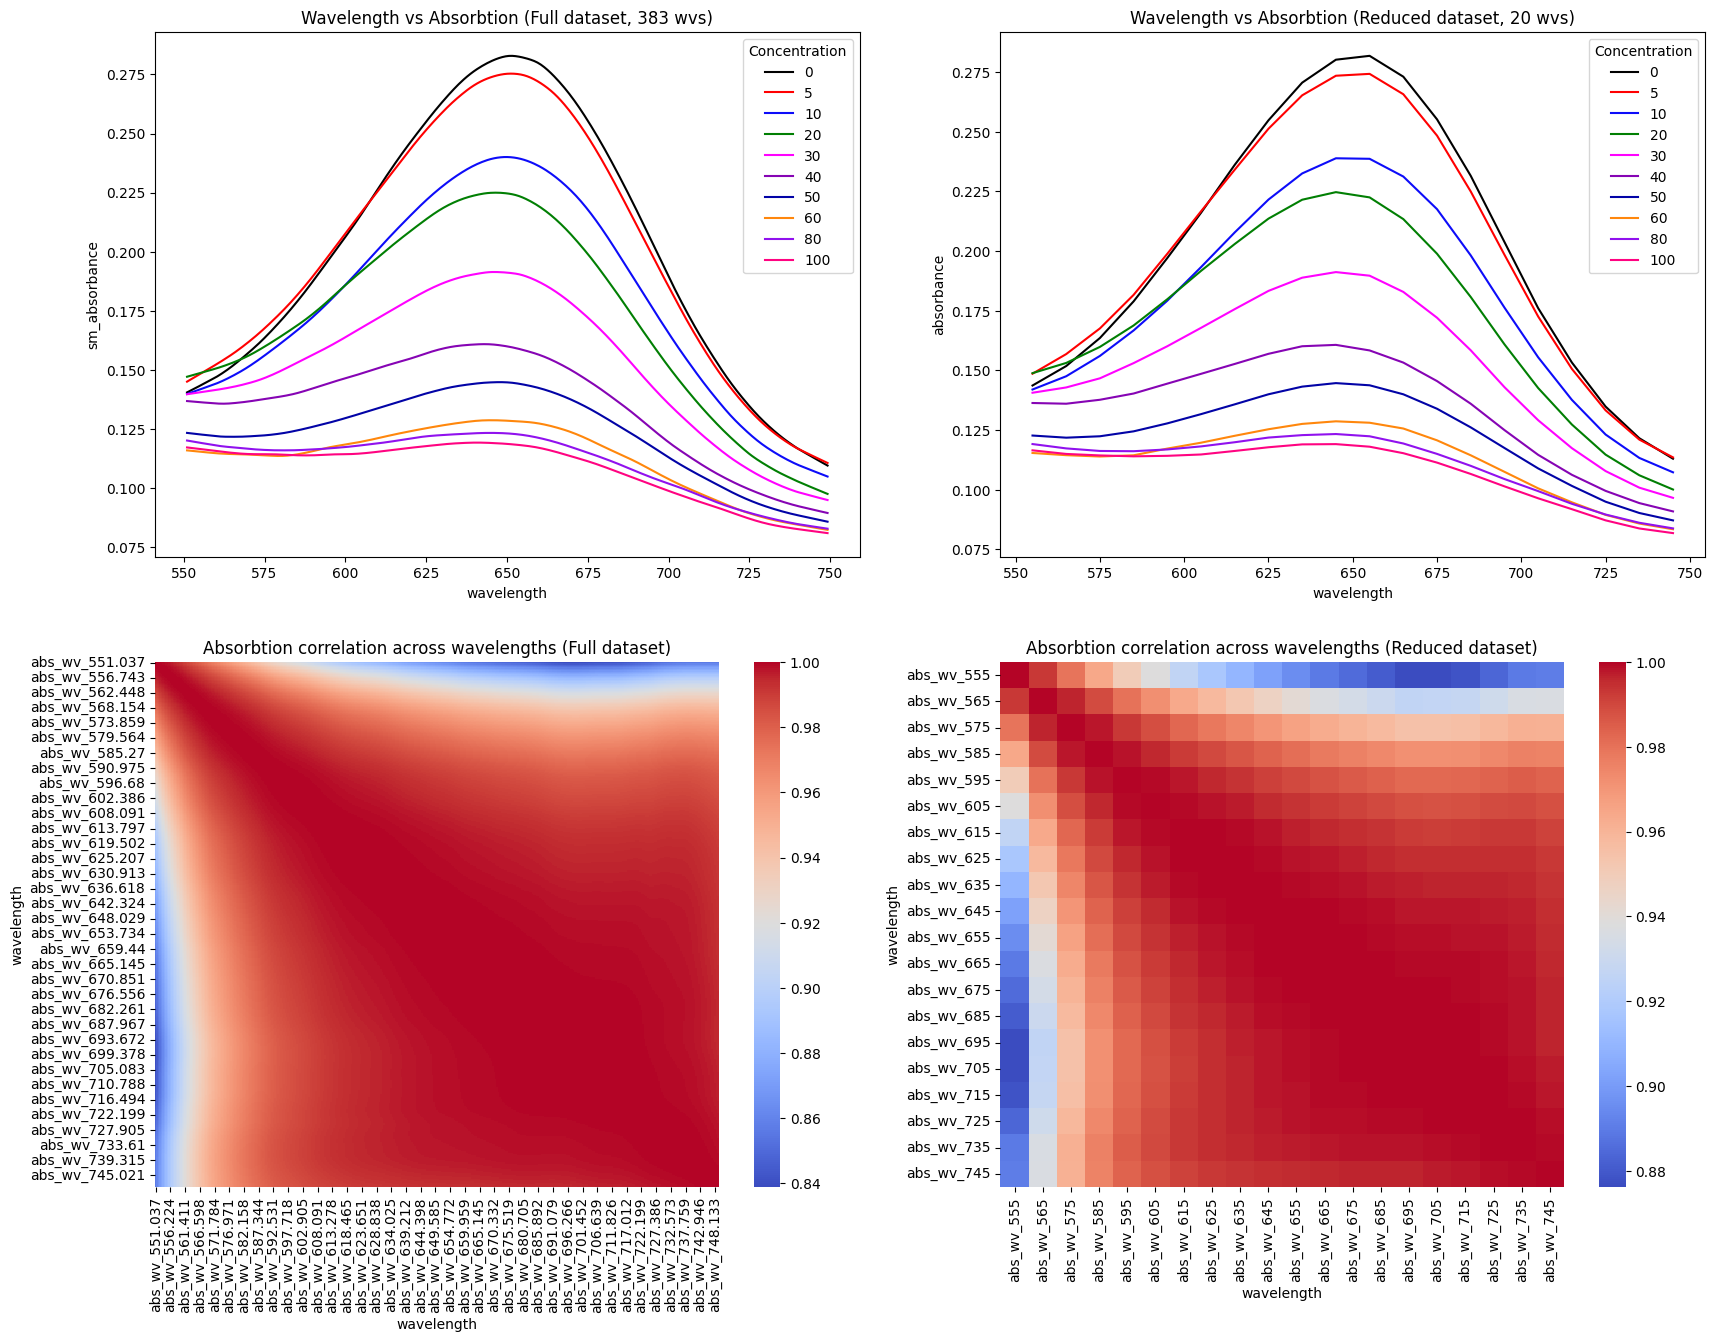

In [25]:
long_data = X_filt.copy(deep=True)
long_data['Concentration'] = y
long_data = long_data.melt(id_vars='Concentration', var_name='wavelength', value_name='absorbance')
long_data['wavelength'] = long_data['wavelength'].str.replace('abs_wv_', '').astype(float)

# create 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs = axs.flatten()
webcolors = ["#000000","#FF0001","#0D0CF9","#017F03","#FF02FF","#8604B4","#0203A6","#FF870C","#9011EE","#FF0381"]
sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[0])
axs[0].set_title(f"Wavelength vs Absorbtion (Full dataset, {len(data)//len(y)} wvs)")
sns.lineplot(data=long_data, x="wavelength", y="absorbance", hue="Concentration", palette=webcolors, ax=axs[1])
axs[1].set_title(f"Wavelength vs Absorbtion (Reduced dataset, {len(long_data)//len(y)} wvs)")
# now compare the correlation heatmaps
sns.heatmap(X[sorted(X.columns)].corr(), cmap='coolwarm', ax=axs[2])
axs[2].set_title("Absorbtion correlation across wavelengths (Full dataset)")
sns.heatmap(X_filt[sorted(X_filt.columns)].corr(), cmap='coolwarm', ax=axs[3])
axs[3].set_title("Absorbtion correlation across wavelengths (Reduced dataset)")
plt.show()

In [26]:
### Iteratively add additional features and measure the drop in MSE
# first we have to fix the names of the columns
# we want to replace all '.' with '_' in the column names
X_filt.columns = X_filt.columns.str.replace('.', '_')

Xy_filt = X_filt.copy(deep=True)
Xy_filt['Concentration'] = y

def determine_best_feat_2_add(current_feats, Xy_filt):
    if len(current_feats) > 0:
        cur_formula = 'Concentration ~ ' + ' + '.join(current_feats)
        
        # first fit the model with the current features
        model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
        results = model.fit()
        cur_mse = results.mse_resid
    else:
        cur_formula = 'Concentration ~ 1'
        cur_mse = np.inf
    
    mse_map = {}
    for col in Xy_filt.columns:
        if col == 'Concentration' or col in current_feats:
            continue
        model = sm.OLS.from_formula(f'{cur_formula} + {col}', data=Xy_filt)
        results = model.fit()
        #print(f'{cur_formula} + {col}', results.mse_resid)
        mse_map[col] = results.mse_resid
    best_feat = min(mse_map, key=mse_map.get)
    if mse_map[best_feat] < cur_mse:
        return best_feat, mse_map[best_feat]
    else:
        return None, None

data_list = []
cur_feats = []
for n_feats in range(1, 10):
    best_feat, best_mse = determine_best_feat_2_add(cur_feats, Xy_filt)
    if best_feat is None:
        break
    cur_feats.append(best_feat)
    data_list.append({'n_feats':n_feats, 'best_feat':best_feat, 'best_mse':best_mse})
    print(n_feats, best_feat, best_mse)
pd.DataFrame(data_list)

1 abs_wv_595 144.91203947274806


,n_feats,best_feat,best_mse
0,1,abs_wv_595,144.912039


In [27]:
### Try all combinations of k = 1 ... 9 features and see which one has the lowest MSE 
def get_best_comb_feats(k,df):
    best_comb = []
    best_mse = np.inf
    feats = [c for c in df.columns if c != 'Concentration']
    
    # iterate over all possible combinations of k features
    total_comb = math.comb(len(feats), k)
    for comb in tqdm(combinations(feats, k), total=total_comb):
        cur_formula = 'Concentration ~ ' + ' + '.join(comb)
        model = sm.OLS.from_formula(cur_formula, data=df)
        results = model.fit()
        cur_mse = results.mse_resid
        if cur_mse < best_mse:
            best_mse = cur_mse
            best_comb = comb
    return best_comb, best_mse

data_list = []
for k in range(1, 9):
    best_comb, best_mse = get_best_comb_feats(k, Xy_filt)
    data_list.append({'n_feats':k, 'best_feats':best_comb, 'best_mse':best_mse})
    print(k, best_comb, best_mse)
att3_data = pd.DataFrame(data_list)

100%|██████████| 20/20 [00:00<00:00, 321.51it/s]


1 ('abs_wv_595',) 144.91203947274806


100%|██████████| 190/190 [00:00<00:00, 262.21it/s]


2 ('abs_wv_685', 'abs_wv_695') 152.33537603112129


100%|██████████| 1140/1140 [00:05<00:00, 209.92it/s]


3 ('abs_wv_555', 'abs_wv_585', 'abs_wv_625') 66.4111809467022


100%|██████████| 4845/4845 [00:27<00:00, 179.37it/s]


4 ('abs_wv_555', 'abs_wv_585', 'abs_wv_675', 'abs_wv_695') 17.148395907484126


100%|██████████| 15504/15504 [01:42<00:00, 151.49it/s]


5 ('abs_wv_555', 'abs_wv_575', 'abs_wv_685', 'abs_wv_725', 'abs_wv_745') 6.902113288318927


100%|██████████| 38760/38760 [05:08<00:00, 125.79it/s]


6 ('abs_wv_555', 'abs_wv_575', 'abs_wv_645', 'abs_wv_655', 'abs_wv_675', 'abs_wv_695') 0.7697737577543514


100%|██████████| 77520/77520 [14:49<00:00, 87.16it/s] 


7 ('abs_wv_555', 'abs_wv_595', 'abs_wv_625', 'abs_wv_635', 'abs_wv_645', 'abs_wv_665', 'abs_wv_695') 0.003485164106789975


100%|██████████| 125970/125970 [36:16<00:00, 57.87it/s]


8 ('abs_wv_565', 'abs_wv_585', 'abs_wv_595', 'abs_wv_615', 'abs_wv_625', 'abs_wv_665', 'abs_wv_685', 'abs_wv_695') 3.7212143500614196e-10


Similar to the results from attempt 2 ... effect is only slightly stronger, so will proceed with attempt 2 collapse for future work.

# Restate the feature reduction step

From the previous section we established that some feature reduction is necessary to reduce the model colinearity and make the search for the optimal k-coefficient model tractable.

The approach I settled on for reducing the colinearity between the features was to rank the wavelengths by variance absorbtion. Then remove wavelengths that correlated with a previously retained wavelength of higher variance at a pearson correlation threshold of 0.999 or greater. 

In [43]:
# redo the feature reduction step according to what was determined earlier
var_map = {}
for col in tqdm([c for c in wide_data.columns if c != 'Concentration']):
    var_map[col] = wide_data[col].var()
# sort the features by the variance descending
sorted_features = sorted(mse_map, key=var_map.get, reverse=True)
thresh = 0.999 # 1 - 1e-4
kept_features = []
for test_feat in sorted_features:
    for feat in kept_features:
        if corr_matrix.loc[test_feat, feat] > thresh:
            break
    else:
        kept_features.append(test_feat)

X = wide_data.drop(columns='Concentration')
X_filt = X[kept_features]

Xy_filt = X_filt.copy(deep=True)
Xy_filt['Concentration'] = y

# replace the "." with "_" in the column names
Xy_filt.columns = Xy_filt.columns.str.replace('.', '_')

100%|██████████| 383/383 [00:00<00:00, 20084.75it/s]


In [78]:
long_data = X_filt.copy(deep=True)
long_data['Concentration'] = y
long_data = long_data.melt(id_vars='Concentration', var_name='wavelength', value_name='absorbance')
long_data['wavelength'] = long_data['wavelength'].str.replace('abs_wv_', '').astype(float)

In [63]:
feats = att2_data['best_feats'].values[0]
cur_formula = 'Concentration ~ ' + ' + '.join(feats)
model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
results = model.fit()
print("train MSE:",results.mse_resid)

train MSE: 145.0000248024146


In [84]:
att2_data['best_feats']

0                                    (abs_wv_596_162,)
1                     (abs_wv_687_967, abs_wv_552_075)
2     (abs_wv_627_801, abs_wv_580_083, abs_wv_555_187)
3    (abs_wv_609_129, abs_wv_580_083, abs_wv_552_07...
4    (abs_wv_652_178, abs_wv_580_083, abs_wv_727_38...
5    (abs_wv_596_162, abs_wv_573_34, abs_wv_727_386...
6    (abs_wv_687_967, abs_wv_573_34, abs_wv_727_386...
7    (abs_wv_652_178, abs_wv_627_801, abs_wv_687_96...
Name: best_feats, dtype: object

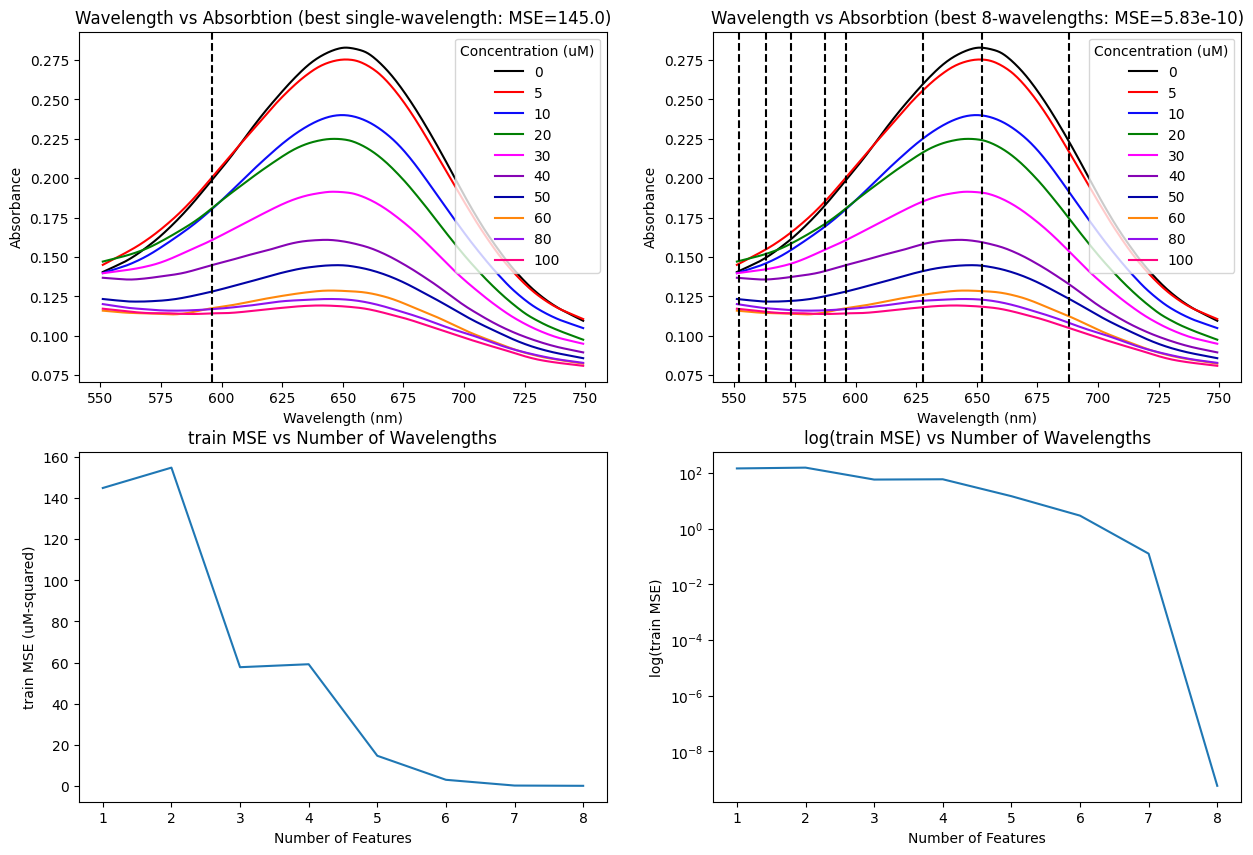

In [93]:
# build lineplot of decreasing MSE when features are added 
# create 2 plots side-by-side
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

feats = att2_data['best_feats'].values[0]
cur_formula = 'Concentration ~ ' + ' + '.join(feats)
model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
results = model.fit()

sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[0])
axs[0].set_title(f"Wavelength vs Absorbtion (best single-wavelength: MSE={round(results.mse_resid,2)})")
# change the legend title
axs[0].legend(title="Concentration (uM)")
axs[0].set_xlabel("Wavelength (nm)")
axs[0].set_ylabel("Absorbance")

# for each feature in the model draw a dashed vertical line at that wavelength
for feat in feats:
    wv = float(".".join(feat.split('_')[-2:]))
    axs[0].axvline(wv, color='black', linestyle='--')

feats = att2_data['best_feats'].values[-1]
cur_formula = 'Concentration ~ ' + ' + '.join(feats)
model = sm.OLS.from_formula(cur_formula, data=Xy_filt)
results = model.fit()

sns.lineplot(data=data, x="wavelength", y="sm_absorbance", hue="Concentration", palette=webcolors, ax=axs[1])
axs[1].set_title("Wavelength vs Absorbtion (best {:}-wavelengths: MSE={:.2e})".format(len(feats),results.mse_resid))
axs[1].legend(title="Concentration (uM)")
axs[1].set_xlabel("Wavelength (nm)")
axs[1].set_ylabel("Absorbance")

# for each feature in the model draw a dashed vertical line at that wavelength
for feat in feats:
    wv = float(".".join(feat.split('_')[-2:]))
    axs[1].axvline(wv, color='black', linestyle='--')

sns.lineplot(data=att2_data, x='n_feats', y='best_mse',ax=axs[2])
axs[2].set_title("train MSE vs Number of Wavelengths")
axs[2].set_xlabel("Number of Features")
axs[2].set_ylabel("train MSE (uM-squared)")
sns.lineplot(data=att2_data, x='n_feats', y='best_mse',ax=axs[3])
axs[3].set_title("log(train MSE) vs Number of Wavelengths")
axs[3].set_xlabel("Number of Features")
axs[3].set_ylabel("log(train MSE)")
axs[3].set_yscale('log')

# Perform a leave-one-out analysis

Since the concentrations range from 0-100 uM we can perform a 8-fold leave-one-out analysis

In [69]:
train_test_results = []
row_is = set(range(10))
for i in range(8):
    for j in range(1,9):
        Xy_filt_train = Xy_filt[Xy_filt.index.isin(row_is - {j})]
        Xy_filt_test = Xy_filt[Xy_filt.index.isin({j})]
        feats = att2_data['best_feats'].values[i]
        cur_formula = 'Concentration ~ ' + ' + '.join(feats)
        model = sm.OLS.from_formula(cur_formula, data=Xy_filt_train)
        results = model.fit()
        #print("train MSE:",results.mse_resid)
        # now generate the predictions for the test set
        y_pred = results.predict(Xy_filt_test)
        # calculate the MSE
        mse = np.mean((y_pred - Xy_filt_test['Concentration'])**2)
        train_test_results.append({"n_features":i+1,'train_MSE':results.mse_resid, 'test_MSE':mse, 'test_index':j})
tr_te_res = pd.DataFrame(train_test_results)

In [70]:
tr_te_res.groupby('n_features').mean()

,train_MSE,test_MSE,test_index
n_features,,,
1,152.996793,1.112498e+02,4.5
2,164.490432,1.359962e+02,4.5
3,58.283252,7.700962e+01,4.5
4,59.649485,9.608435e+01,4.5
5,14.535189,5.411971e+01,4.5
6,3.134112,7.727889e+00,4.5
7,0.164886,3.362163e-01,4.5
8,NaN,1.397736e-07,4.5


In [88]:
tr_te_res.groupby('n_features').agg({'train_MSE':'mean','test_MSE':'median'})

,train_MSE,test_MSE
n_features,,
1,152.996793,7.837874e+01
2,164.490432,7.327667e+01
3,58.283252,3.956611e+01
4,59.649485,5.741883e+01
5,14.535189,2.385676e+01
6,3.134112,7.298422e+00
7,0.164886,3.085178e-01
8,NaN,1.741395e-08


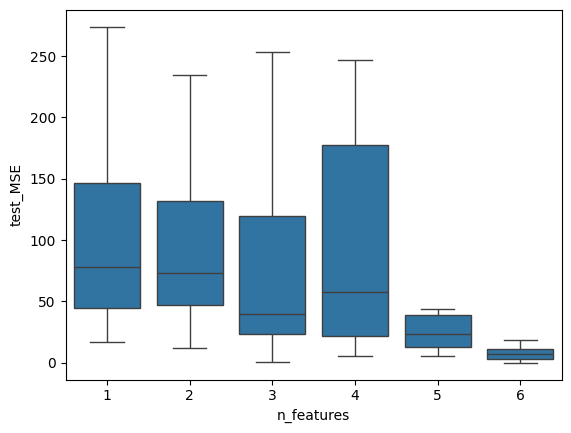

In [61]:

ax = sns.boxplot(x=tr_te_res['n_features'], y = tr_te_res['test_MSE'], showfliers=False)
# change the y-axis to log scale
#ax.set_yscale('log')

# misc

ideas I had at the beginning that were abandonned:

1. test increasingly larger windows around the wavelength of highest variance
   1. fix additional points to 4
   2. test 10 nm around wavelength of highest variance
   3. test 20 nm " " " " "
   4. test 40 nm " " " " "
2. with the optimal window size from above, test different densities of input data
   1. 4 points (ctrl)
   2. 8 points
   3. 16 points
   4. 32 points
3. Note: for all modeling I will use a L1-penalized linear regression model (LASSO)

## Test different windows of 4 surrounding points

In [28]:
# first establish approximately how many wavelengths in the data correspond to ~10 nm intervals
wavelengths = sorted(np.unique(data['wavelength']))
wavelengths[19] - wavelengths[0]

np.float64(9.854771784232412)

In [29]:
# so about every 19 wavelength records corresponds to a 10 nm interval
conversion_factor = 19
dists = [1,2,4]
# get the index corresponding to the wv_highest_variance
idx = np.where(wavelengths == wv_highest_variance['wavelength'].values[0])[0][0]
for dist in dists:
    wavelengths_to_use = wavelengths[idx-(2*dist*conversion_factor):idx+(2*dist*conversion_factor)+1:(dist*conversion_factor)]
    print(wavelengths_to_use)
    df = pd.DataFrame(data[data['wavelength'].isin(wavelengths_to_use)])
    df["wavelength"] = df["wavelength"].round().astype(int)
    # convert the data to wide format
    df = df.pivot(index='Concentration', columns='wavelength', values='sm_absorbance')
    rename_dict = {c:f"abs_wv_{c}" for c in df.columns}
    df = df.rename(columns=rename_dict).reset_index()
    # fit a lasso model with the data from the selected wavelengths
    # using sklearn
    X = df.drop(columns=['Concentration'])
    # add a constant column to the data
    X = sm.add_constant(X)
    y = df['Concentration']
    lasso = Lasso(alpha=0.005)
    lasso.fit(X, y)
    # get the MSE of the model
    y_pred = lasso.predict(X)
    mse = np.mean((y - y_pred)**2)
    print(mse)
    # get the number of non-zero coefficients
    print(np.sum(lasso.coef_ != 0))
    
    

[np.float64(632.4688796680498), np.float64(642.3236514522822), np.float64(652.1784232365146), np.float64(662.0331950207469), np.float64(671.8879668049793)]
126.34437560878428


1
[np.float64(612.7593360995851), np.float64(632.4688796680498), np.float64(652.1784232365146), np.float64(671.8879668049793), np.float64(691.597510373444)]
118.94977957056707
2
[np.float64(573.3402489626556), np.float64(612.7593360995851), np.float64(652.1784232365146), np.float64(691.597510373444), np.float64(731.0165975103735)]
116.33852509509659116.33852509509659
2


In [30]:
lasso.coef_

array([   0.        , -280.40057676, -550.26011551,   -0.        ,
          0.        ,   -0.        ])

Seems like this approach is flawed because in this data there is a large amount of co-linearity between the selected points. This means that even if I select 4 points the Lasso will force the selection to only 1 or 2 points ... not what was meant to be tested I think.

## Fit a lasso model using the data from multiple wavelengths of the data

In [31]:
# generate a list of alpha values to test for the Lasso LR model
alphas = np.logspace(-3.1, -1, 100)

miter = 100000
n_rep = 1

lasso_results = []
for alph in tqdm(alphas):
    for rep in range(n_rep):
        datum = {'alpha':alph, 'n_coefficients':None, 'mse':None, "rep":rep}
        lasso = Lasso(alpha=alph, max_iter=miter)
        lasso.fit(X_filt, y)
        # check that the model converged
        if lasso.n_iter_ == miter:
            #print(f"Model did not converge for alpha={alph} ({lasso.n_iter_}/{miter} iterations)")
            pass
        else:
            nz_coef = [colname for c,colname in zip(lasso.coef_, X_filt.columns) if c != 0]
            df = pd.DataFrame(wide_data[nz_coef + ['Concentration']])
            # rename the coefficient to be wv1, wv2 etc
            df = df.rename(columns={colname:f"wv{i}" for i,colname in enumerate(nz_coef)})
            nz_coefs = [f"wv{i}" for i in range(len(nz_coef))]
            # now fit the model with the selected features
            model = sm.OLS.from_formula(f'Concentration ~ {" + ".join(nz_coefs)}', data=df)
            results = model.fit()
            ncoeff = np.sum(lasso.coef_ != 0)
            mse = results.mse_resid
            if np.isnan(mse):
                mse = None
                ncoeff = None
            datum["n_coefficients"] = ncoeff
            datum["mse"] = mse
        lasso_results.append(datum)
lasso_results = pd.DataFrame(lasso_results)
lasso_results

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\craut\.virtualenvs\colorimetry_ML-6CtRR2jE\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+00, tolerance: 9.923e-01
  model = cd_fast.enet_coordinate_descent(
  1%|          | 1/100 [00:00<00:18,  5.27it/s]


KeyError: "['abs_wv_555', 'abs_wv_575', 'abs_wv_585', 'abs_wv_615', 'abs_wv_625', 'abs_wv_675', 'abs_wv_705', 'abs_wv_745'] not in index"

In [ ]:
avg_results = lasso_results[~pd.isna(lasso_results.mse)].groupby('alpha').agg({'n_coefficients':'mean', 'mse':'mean'}).reset_index()

In [ ]:
avg_results[~pd.isna(avg_results.n_coefficients)]

,alpha,n_coefficients,mse
0,0.001014,6.0,64.762737
1,0.001065,5.0,86.468095
2,0.001118,6.0,114.693586
3,0.001174,6.0,114.693586
4,0.001233,6.0,114.693586
...,...,...,...
90,0.082253,1.0,163.452374
91,0.086370,1.0,163.452374
92,0.090693,1.0,163.452374
93,0.095233,1.0,163.452374


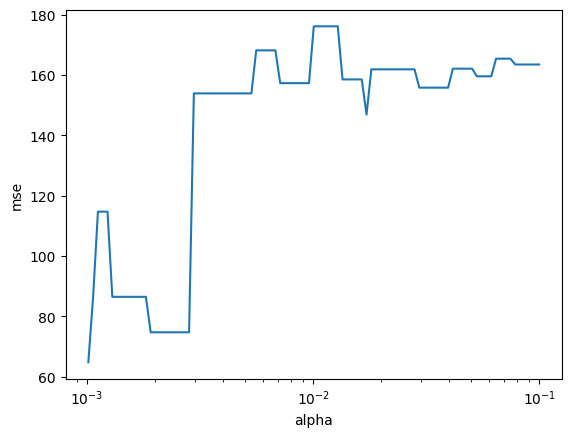

In [ ]:
# show the change in MSE against alpha via a line plot
ax = sns.lineplot(data=lasso_results, x='alpha', y='mse', errorbar="sd")
ax.set_xscale('log')

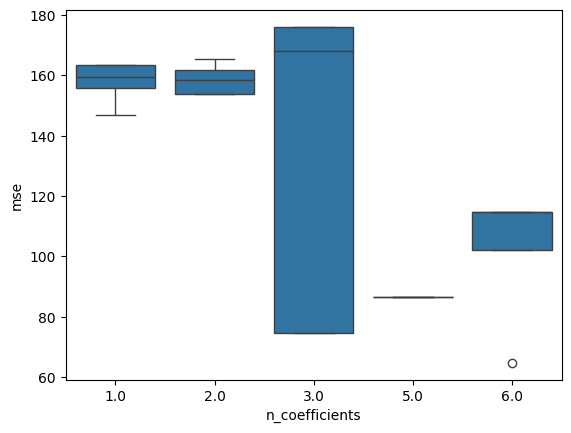

In [ ]:
ax = sns.boxplot(data=lasso_results, x='n_coefficients', y='mse')